In [2]:
%reload_ext autoreload
%autoreload 2

# Jos haluaa saada keskellä koodia "pretty printin" niinkuin cellin lopussa
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import sys
import pandas as pd
import time
import timeit
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from clean_velocities import *
from draw_node_amount import *
from draw_cluster_routes import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from klusterointi import *

In [3]:
df = database_query("SELECT * FROM DATA LIMIT 1000000")
df

ajokerta  node_id           timestamp   x   y  grid_id  distance  \
0              2        1 2020-06-25 15:21:46  28  15      628  0.962081   
1              2        1 2020-06-25 15:21:47  28  15      628  1.028834   
2              2        1 2020-06-25 15:21:47  28  15      628  0.648460   
3              2        1 2020-06-25 15:21:47  28  15      628  0.826075   
4              2        1 2020-06-25 15:21:50  26  15      626  1.753767   
...          ...      ...                 ...  ..  ..      ...       ...   
999995      3549       10 2020-07-28 14:56:27  11  27     1091  1.050000   
999996      3549       10 2020-07-28 14:56:27  11  28     1131  0.430116   
999997      3549       10 2020-07-28 14:56:28  11  27     1091  1.427901   
999998      3549       10 2020-07-28 14:56:28  11  27     1091  0.441022   
999999      3549       10 2020-07-28 14:56:28  12  26     1052  0.891067   

           kesto  dayofweek  current_hour  
0       6812.007          3             8  
1       6812.007          3             8  
2       6812.007          3             8  
3       6812.007          3             8  
4       6812.007          3             8  
...          ...        ...           ...  
999995    80.002          1             7  
999996    80.002          1             7  
999997    80.002          1             7  
999998    80.002          1             7  
999999    80.002          1             7  

[1000000 rows x 10 columns]

In [4]:
distances = df.groupby(['ajokerta'])['distance'].sum().to_dict()
df["distance"] = df['ajokerta'].map(distances)

In [5]:
%%time
df = df_to_features(df)

CPU times: user 11.8 s, sys: 11.1 ms, total: 11.8 s
Wall time: 11.8 s


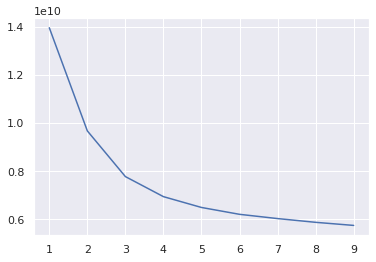

In [6]:
ideal_k(df)

# Haetaan toisesta tietokannasta hyvät reitit

In [7]:
df = database_query("SELECT * FROM REITIT")
df

ajokerta  node_id           timestamp  grid_x  grid_y  grid_id  \
0            2        1 2020-06-25 15:21:46      28      15      628   
1            2        1 2020-06-25 15:21:47      28      15      628   
2            2        1 2020-06-25 15:21:47      27      15      627   
3            2        1 2020-06-25 15:21:47      27      15      627   
4            2        1 2020-06-25 15:21:50      26      15      626   
...        ...      ...                 ...     ...     ...      ...   
8330        32        1 2020-07-03 17:58:28       3      35     1403   
8331        32        1 2020-07-03 17:58:29       3      35     1403   
8332        32        1 2020-07-03 17:58:29       3      35     1403   
8333        32        1 2020-07-03 17:58:30       3      35     1403   
8334        32        1 2020-07-03 17:58:32       2      35     1402   

      distance     kesto  dayofweek  current_hour     x     y  
0     0.962081  6812.007          3             8  2876    21  
1     1.028834  6812.007          3             8  2832   114  
2     0.648460  6812.007          3             8  2770   133  
3     0.826075  6812.007          3             8  2760    51  
4     1.753767  6812.007          3             8  2601   125  
...        ...       ...        ...           ...   ...   ...  
8330  0.280000   708.000          4            10   100  2516  
8331  0.158114   708.000          4            10   105  2501  
8332  0.100000   708.000          4            10    99  2493  
8333  0.127279   708.000          4            10    90  2484  
8334  0.186011   708.000          4            10    79  2469  

[8335 rows x 12 columns]

# Muutetaan piirrematriisiksi

In [8]:
df2 = df_to_features(df)
df2

ajokerta  node_id     kesto  dayofweek  current_hour  distance     0  \
0          2        1  6812.007          3             8  0.962081   830   
1          3        1  1440.522          3             9  1.426359   931   
2          4        1   771.016          3            10  1.582940  1235   
3          5        1   265.000          3            12  2.480181  1163   
4          7        1   660.002          4            12  0.644981  1075   
5          8        1   877.001          4            12  1.232599   594   
6         10        1   107.002          6             6  7.750000  1130   
7         11        1   210.998          6             9  2.441352  1127   
8         13        1   636.001          0             8  0.659697   772   
9         14        1  1729.000          0             9  1.074663   794   
10        15        1   479.002          0            10  0.167631   674   
11        16        1  1323.999          0            11  0.872067  1590   
12        17        1   459.998          0            12  1.166919   751   
13        18        1   974.998          0            13  0.664831   714   
14        19        1   580.999          1             4  0.482701   787   
15        21        1   529.000          1             9  0.645600   754   
16        22        1   577.998          1            10  0.310161   628   
17        23        1   415.000          2             5  0.966902   911   
18        24        1  5128.998          2             9  0.628013   654   
19        25        1   491.000          2            10  0.480416  1130   
20        28        1   870.000          4             3  0.094340   554   
21        29        1  1408.000          4             6  0.551453  1411   
22        30        1   356.002          4             8  0.550091  1348   
23        31        1   678.001          4             8  0.976217   674   
24        32        1   708.000          4            10  0.710211   633   

       1     2     3  ...    15    16    17    18    19    20    21    22  \
0    595  1347  1268  ...   905  1306  1109  1173  1052   985   794   825   
1    751   932   732  ...   851   656   812   830  1050   692  1087   653   
2   1555   754   755  ...  1576   857  1565  1084  1320   635   914  1075   
3   1355   788  1395  ...  1564  1482  1114   708  1090  1087  1592   947   
4   1035   701   702  ...  1155  1361  1395  1116   741  1533  1354  1202   
5   1035  1115  1075  ...  1104  1400  1362  1361  1048  1055  1481   914   
6    698  1015   977  ...  1014  1093   624   734   815   660   661   855   
7    788  1328  1128  ...  1407  1053  1524  1568  1527  1028  1533   815   
8    852   812   773  ...   732  1572   774  1044  1554   693  1028   648   
9    714   754  1164  ...  1194   872  1187  1431   753   709   674   633   
10   874   834  1369  ...  1349   714  1074  1351  1508   994  1275  1350   
11   907   868  1148  ...  1108  1311  1274  1589   828  1394  1350  1314   
12  1087   714  1243  ...   754  1402  1443   713  1401  1549   953   834   
13   907   710   947  ...   872   793   668   674   834   832   794   628   
14   988  1028   908  ...  1148  1567   654  1505  1314  1066  1187  1031   
15   833   794   633  ...   793  1067   914  1267   673   874  1113   872   
16  1431   658  1320  ...  1047  1400  1471  1430   827  1125  1085  1512   
17   832  1111   912  ...  1149   788  1190  1333  1293   748  1213   698   
18  1208   695  1092  ...  1125  1086   776   816   936  1084  1087  1089   
19  1368  1328   699  ...  1363  1129   658  1168  1348  1131  1123  1084   
20   834  1428  1563  ...  1228  1427  1276   659  1155  1074  1361   664   
21   907  1394  1515  ...  1431   809  1311  1410  1281  1351  1395  1322   
22   889   767   927  ...  1388   930   828   968  1420  1506  1503   807   
23  1400   794  1565  ...  1567  1527   713  1564  1574  1154   634  1322   
24  1227   833  1450  ...  1114  1504  1408  1467  1546  1074  1403  1407   

      23    24  
0    83

# Klusteroidaan reitit, niin että päivä korreloisi reitin keston kanssa

In [9]:
from sklearn.cluster import AgglomerativeClustering
#df2 = df_reitit[['x', 'y']].sample(n=10000, random_state=1)

potato = df2[['ajokerta','dayofweek','kesto']]
#potato = df2.copy()#df2.iloc[:,5:-1]
#potato['ajokerta'] = df2['ajokerta']

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
y_kmeans = cluster.fit_predict(potato)

potato["predicted"] = y_kmeans

ajot = df2["ajokerta"].unique()
oltava =  potato.index.unique()

poistettavat = set(ajot)-set(oltava)

data = potato[~potato['ajokerta'].isin(poistettavat)]
#print(data["ajokerta"].unique())
data["pred"] = None

zip_iterator = zip(oltava, y_kmeans)
parit = dict(zip_iterator)

df_pred = df.copy()
df_pred['pred'] = df_pred["ajokerta"].map(parit).fillna(data["pred"])
df_pred['predicted'] = df_pred["ajokerta"].map(parit).fillna(data["predicted"])
#df_pred[['x','y']] = df[['x','y']]
data['pred'] = data["ajokerta"].map(parit).fillna(data["pred"])
#data[['x','y']] = df[['x','y']]
data

ajokerta  dayofweek     kesto  predicted  pred
0          2          3  6812.007          3     1
1          3          3  1440.522          2     0
2          4          3   771.016          1     1
3          5          3   265.000          0     1
4          7          4   660.002          1     0
5          8          4   877.001          1     1
6         10          6   107.002          0     0
7         11          6   210.998          0     2
8         13          0   636.001          1     1
9         14          0  1729.000          2     0
10        15          0   479.002          0     0
11        16          0  1323.999          2     0
12        17          0   459.998          0     0
13        18          0   974.998          1     4
14        19          1   580.999          0     0
15        21          1   529.000          0     2
16        22          1   577.998          0     0
17        23          2   415.000          0     1
18        24          2  5128.998          4     1

# Tiputetaan ajokerrat, jotka ei klusteroituneet

In [10]:
df_pred = df_pred.dropna()
df_pred

ajokerta  node_id           timestamp  grid_x  grid_y  grid_id  \
1            2        1 2020-06-25 15:21:47      28      15      628   
2            2        1 2020-06-25 15:21:47      27      15      627   
3            2        1 2020-06-25 15:21:47      27      15      627   
4            2        1 2020-06-25 15:21:50      26      15      626   
5            2        1 2020-06-25 15:21:50      25      15      625   
...        ...      ...                 ...     ...     ...      ...   
6416        24        1 2020-07-01 16:14:16      14      16      654   
6417        24        1 2020-07-01 16:14:27      14      16      654   
6418        24        1 2020-07-01 16:14:54      14      16      654   
6419        24        1 2020-07-01 16:14:55      14      16      654   
6420        24        1 2020-07-01 16:15:07      14      16      654   

      distance     kesto  dayofweek  current_hour     x    y  check  pred  \
1     1.028834  6812.007          3             8  2832  114    2.0   1.0   
2     0.648460  6812.007          3             8  2770  133    2.0   1.0   
3     0.826075  6812.007          3             8  2760   51    2.0   1.0   
4     1.753767  6812.007          3             8  2601  125    2.0   1.0   
5     0.310644  6812.007          3             8  2570  127    2.0   1.0   
...        ...       ...        ...           ...   ...  ...    ...   ...   
6416  0.070711  5128.998          2             9  1372  193   24.0   1.0   
6417  0.111803  5128.998          2             9  1367  183   24.0   1.0   
6418  0.142127  5128.998          2             9  1358  172   24.0   1.0   
6419  0.056569  5128.998          2             9  1354  168   24.0   1.0   
6420  0.257099  5128.998          2             9  1360  148   24.0   1.0   

      predicted  
1           1.0  
2           1.0  
3           1.0  
4           1.0  
5           1.0  
...         ...  
6416        1.0  
6417        1.0  
6418        1.0  
6419        1.0  
6420        1.0  

[6420 rows x 15 columns]

# Piirretään klusterit
## Legendissä näkyy ajokerrat, jotka löytyvät klusterista

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[1. 0. 2. 4.]
Ajokerrat:  4


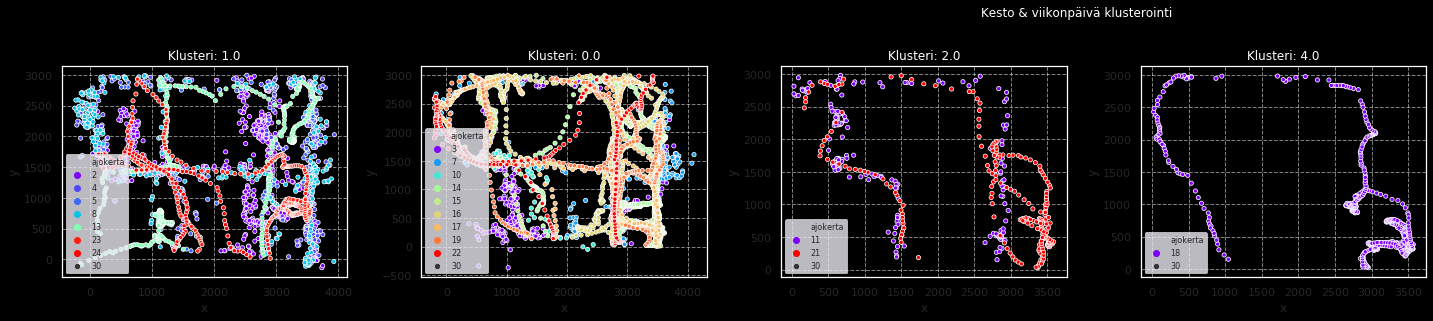

In [16]:
draw_cluster_route(df_pred, 'predicted', 'ajokerta')

Ajokerrat:  24


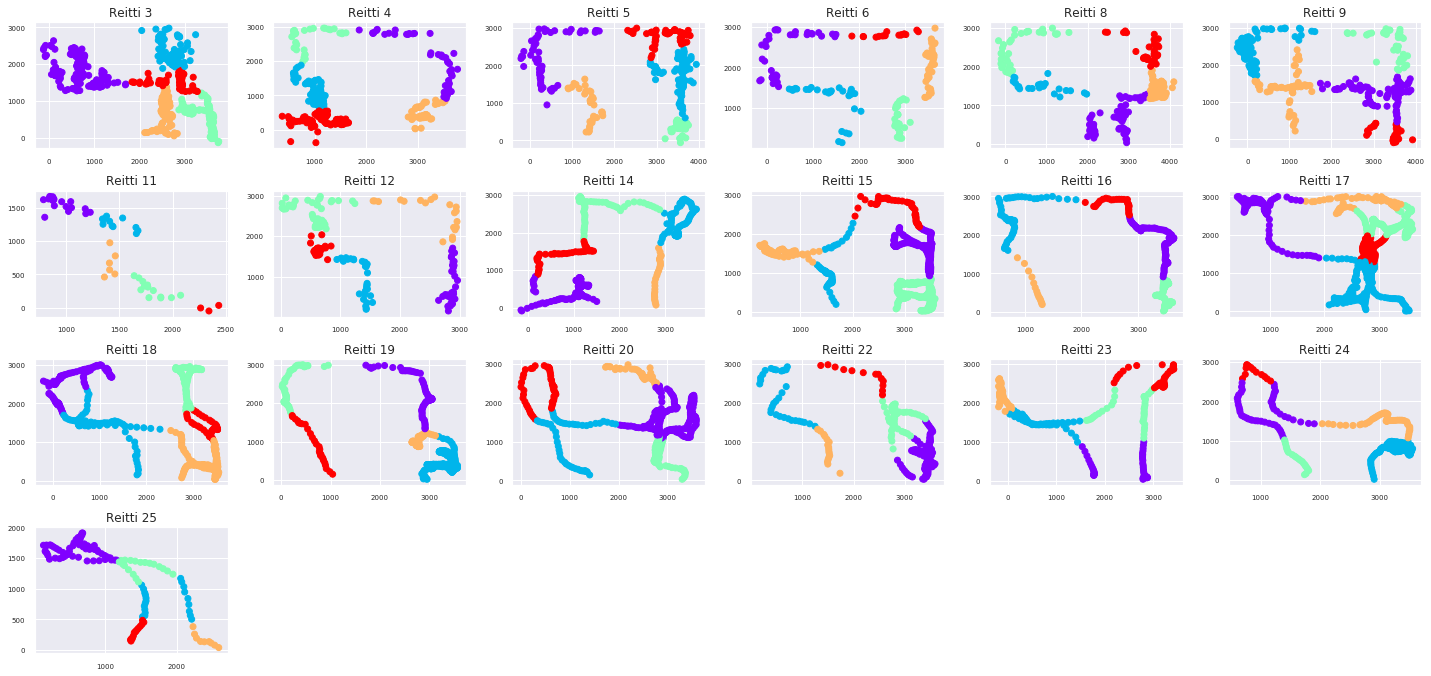

In [17]:
import matplotlib.colors as pltc
from random import sample
import matplotlib.animation as animation

def draw_cluster(df, column):
    ajot = df[column].unique()
    ajot_len = max(df[column].unique())

    print("Ajokerrat: ",ajot_len)
    
    Cols = 6

    Rows = ajot_len // Cols 
    Rows += ajot_len % Cols
    
    Position = range(1,ajot_len + 1)
    
    plt.figure(figsize=(20,10),facecolor=(1, 1, 1))
        
    #cluster.fit_predict(df)
    #plt.figure(figsize=(10, 7))
    #plt.title("Agglomerative Clustering")
    #plt.scatter(df.iloc[:,0], df.iloc[:,1], c=cluster.labels_, cmap='rainbow')

    #plt.rcParams['figure.facecolor'] = 'white'
    #fig.patch.set_facecolor('black')
    for i,k in zip(ajot,range(ajot_len)):
        df_temp = df[df[column] == i][['x', 'y']]
        cluster.fit_predict(df_temp)
        #plt.subplot((ajot_len/5)+1,6,i+1)
        plt.subplot(Rows,Cols,Position[k])
        plt.scatter(df_temp.iloc[:,0], df_temp.iloc[:,1], c=cluster.labels_, cmap='rainbow')
        #plt.plot(df[df["ajokerta"] == i]['x'], df[df["ajokerta"] == i]['y'], color=np.random.random(3))#np.random.random(3)
        #plt.scatter(in_x, in_y, color='darkorange', marker='s', s=2)
        #plt.scatter(out_x, out_y, color='green', marker='s', s=2)
        plt.title(f"Reitti {i+1}")
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        #plt.xlim(0, 40)
        #plt.ylim=(0, 40)
        #plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
draw_cluster(df_pred,'ajokerta')

# Dendogrammi
Dendrogrammi havainnollistaa, kuinka kukin klusteri koostuu piirtämällä U-muotoinen linkki ei-yksittäisen klusterin ja sen lasten välille. 

- U-lenkin yläosa osoittaa klusterin sulautumisen.
- U-lenkin kaksi osaa osoittavat, mitkä klusterit yhdistettiin. 
- U-lenkin kahden haaran pituus edustaa lapsiklustereiden välistä etäisyyttä. 
    - Se on myös kofeneettinen etäisyys kahden lapsiryhmän alkuperäisten havaintojen välillä.

In [18]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

# generate the linkage matrix
#X = df_pred[['ajokerta', 'dayofweek', 'kesto']].values
X = df2[['distance', 'current_hour']]
#X = df2
Z = linkage(X,
            method='complete',  # dissimilarity metric: max distance across all pairs of 
                                # records between two clusters
            metric='euclidean'
    )                           # you can peek into the Z matrix to see how clusters are 
                                # merged at each iteration of the algorithm

# calculate full dendrogram and visualize it
'''plt.figure(figsize=(30, 10))
dendrogram(Z)
plt.show()'''

'''# retrive clusters with `max_d`
from scipy.cluster.hierarchy import fcluster
max_d = 25       # I assume that your `Latitude` and `Longitude` columns are both in 
                 # units of miles
clusters = fcluster(Z, max_d, criterion='distance')'''

plt.figure(figsize=(30, 10))
dn = hierarchy.dendrogram(Z)

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1],
                           above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

NameError: name 'linkage' is not defined

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit on training set only.
df3 = scaler.fit_transform(df2)
# Apply transform to both the training set and the test set.


In [28]:
df3

array([[-1.65331796e+00,  0.00000000e+00,  3.79090140e+00,
         3.01651290e-01, -3.63843898e-01, -1.49896313e-01,
        -3.02948185e-01, -1.60017226e+00,  1.66454755e+00,
         6.23761944e-01,  9.35995033e-01,  1.02876752e+00,
        -1.56618787e+00,  7.36840335e-01,  1.40577471e+00,
        -3.47389275e-01,  7.19023225e-01,  2.21076325e-01,
         9.37617526e-01, -1.73813730e+00, -9.01896204e-01,
        -1.01722527e+00,  4.85763646e-01,  7.79371945e-02,
         4.66144287e-02, -3.58049203e-01, -2.10008517e-01,
        -1.25059255e+00, -5.76612891e-01, -7.17985930e-01,
        -2.97112704e-01],
       [-1.54368149e+00,  0.00000000e+00,  2.01119403e-01,
         3.01651290e-01,  3.16385999e-02,  1.68150902e-01,
         5.88986300e-02, -9.88041627e-01, -3.30520599e-02,
        -1.25876284e+00, -1.77618325e+00, -1.16933207e+00,
        -1.35557581e+00, -1.55839927e+00, -1.32085674e+00,
        -8.00671334e-01,  1.65450180e+00, -1.34276946e+00,
        -6.69811073e-01, -1.37

In [33]:
from sklearn.decomposition import PCA
# Make an instance of the Model
#pienennetään dimensiot 50:neen
n_components = 20
pca = PCA(n_components=n_components, whiten=True)

code = pca.fit_transform(df2)
print('train_pca:', code.shape)


train_pca: (25, 20)


array([[ 3.73342844e+00, -3.26347052e-01, -8.09358414e-02,
         9.05287399e-01,  1.11210624e-01, -4.18361225e-01,
        -4.03803094e-01, -3.18212463e-01, -5.74705285e-01,
        -4.44663171e-01, -7.65504491e-03,  6.20602627e-01,
         4.19396669e-01,  1.78116189e-01, -4.55830904e-01,
         5.59275929e-01,  1.11635519e+00, -1.22359398e-01,
        -6.18933068e-01, -1.75743110e-01],
       [ 2.12579586e-01,  2.03688406e+00,  1.01941060e-01,
         3.27970111e-01,  1.16973271e-01, -9.36863015e-02,
        -6.80902380e-01,  3.16167339e-01, -7.51842487e-01,
         1.42692797e-01, -1.69481379e+00, -9.49817875e-01,
        -7.76655950e-01,  4.73810051e-01, -2.80448419e-01,
        -9.82595045e-01, -2.00420188e+00, -7.74434620e-01,
         1.29835238e+00, -1.35510701e+00],
       [-2.67476276e-01, -4.79195751e-01,  7.29159521e-01,
        -5.10048250e-01, -3.75009805e-01, -6.66813317e-01,
         4.05372319e-02,  3.84783872e+00, -3.56107407e-01,
        -5.18705369e-01, -4.6

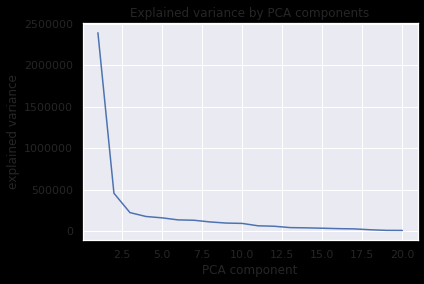

In [32]:
plt.figure()
plt.plot(np.arange(n_components)+1, pca.explained_variance_)
plt.title('Explained variance by PCA components')
plt.ylabel('explained variance')
plt.xlabel('PCA component');

In [38]:
code2 = pd.DataFrame(data=code, columns=['ajokerta',	'node_id',	'kesto',	'dayofweek',	'current_hour',	'distance,'	'0',	'1',	'2',	'3','4','5','6','7','8','9','10','11','12','13','14'])

In [39]:
code2

ajokerta   node_id     kesto  dayofweek  current_hour  distance,0  \
0   3.733428 -0.326347 -0.080936   0.905287      0.111211   -0.418361   
1   0.212580  2.036884  0.101941   0.327970      0.116973   -0.093686   
2  -0.267476 -0.479196  0.729160  -0.510048     -0.375010   -0.666813   
3  -0.601703 -0.872498 -0.095463  -0.512531     -1.368253    1.700615   
4  -0.332212  0.140930 -0.904046  -0.931033     -0.564155    0.640214   
5  -0.176572 -0.767082  0.386964   0.836668      0.377240    0.195211   
6  -0.618005  1.715110  0.103150   0.227796      0.223414   -0.344152   
7  -0.592593 -0.876877 -0.915108   1.620990     -0.131798   -1.551752   
8  -0.321336 -0.191096  0.772663   1.334537      1.836388    2.273621   
9   0.409139  0.892114  0.236457  -0.507106     -0.384216   -0.884182   
10 -0.455746  0.182269  0.297183  -1.330750     -0.531954   -1.554969   
11  0.084023 -0.865139 -1.320004  -0.724433     -1.202638    0.281206   
12 -0.417135 -0.236861  0.622960   1.111233     -1.510264    1.522203   
13 -0.078954  1.841034 -0.387411  -0.140251     -0.245814    0.896090   
14 -0.391726  0.193139  0.236671  -0.357427      0.978120    0.353245   
15 -0.394268  1.327009 -0.151693  -0.520846     -0.155413    0.418035   
16 -0.351562 -1.374593  1.024936  -0.670271     -1.148721    0.437185   
17 -0.450099  0.942541 -0.426360   0.482739     -0.350017   -1.646774   
18  2.585635  0.190265  0.108221  -1.103117      0.202111    0.805579   
19 -0.450192  0.166929 -1.119314  -1.219357      1.341120    0.253615   
20 -0.099838  0.071674  1.306058   2.406274     -1.295053   -0.718102   
21  0.150126 -1.599138 -1.434242  -0.560737     -0.420521   -0.624924   
22 -0.523638 -0.203860 -1.960858   1.002003      1.132706    0.194526   
23 -0.323766 -0.558343  2.901826  -1.338815      1.056466   -0.739888   
24 -0.328107 -1.348869 -0.032757   0.171223      2.308078   -0.727742   

           1         2         3         4         5         6         7  \
0  -0.403803 -0.318212 -0.574705 -0.444663 -0.007655  0.620603  0.419397   
1  -0.680902  0.316167 -0.751842  0.142693 -1.694814 -0.949818 -0.776656   
2   0.040537  3.847839 -0.356107 -0.518705 -0.468375 -0.308104  0.019426   
3  -1.720263  0.269104  0.913201  0.601907  1.227762 -0.192072 -1.365278   
4   1.502701  0.244686  1.586259  0.395193 -1.963303  1.420006 -0.322927   
5  -0.199169 -0.745045  2.306524 -1.363509 -0.255610 -0.268728 -1.587271   
6  -0.089709  0.468204  0.362433  0.090728  1.018502  2.268790  1.935650   
7  -0.035185  0.899167 -0.040078 -0.675359 -0.064414 -0.076113 -0.938789   
8  -1.286269  0.560589 -0.247970 -1.678334  0.012612 -0.326006  0.938709   
9   0.671029 -0.262287 -0.136274 -1.249899  0.886251 -1.384654  0.172323   
10 -1.207453 -1.188623  0.066775  0.446853  0.460895 -1.043747 -0.280491   
11  0.252177 -0.379810 -2.136307 -1.419628  0.501579  2.063254 -0.752114   
12  0.874830 -0.414467 -2.219541  1.550237 -0.946514 -1.316613  0.167257   
13  0.616997 -0.054697  0.339741 -0.006464  2.534374 -0.810938  0.283741   
14 -0.100566 -1.174966 -0.516881 -0.279808 -0.391792  1.044889 -1.017459   
15  0.400094 -1.038885 -0.357596 -1.437526 -1.046560 -0.139145 -0.363577   
16  1.795567 -0.276507  0.812365 -0.837569  0.050935 -0.451627  2.095473   
17  0.069128  0.179133  0.257594 -0.257071 -0.250014 -0.541852 -0.178722   
18  0.597309  0.707695  1.113370  1.243271  0.055833 -0.392052 -0.678058   
19 -1.332283 -0.016687  0.179995  1.114418 -1.448610 -0.031107  1.402584   
20 -0.466145 -0.817235  0.992880  1.406949 -0.317161  1.131067  0.578964   
21 -1.753100 -0.554924 -0.076134  0.116743 -0.040071 -0.728908  1.670414   
22  0.869327  0.613042 -0.298107  1.718127  1.384364  0.142235 -0.701365   
23 -0.325340 -0.002008 -0.975067  0.924394  0.651574  1.122010 -0.883216   
24  1.910490 -0.861272 -0.244528  0.417024  0.110213 -0.851369  0.161988   

           8         9        10        11        12        13        14  
0   0.178116 -0.455831  0.559276  1.116355 -0.122359 